# Change-Point detection problem

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm


%matplotlib inline

In [2]:
def generator_normal(m0, std0, m1, std1, train_size, theta, n_after_theta=1000):
    """
    Generate process: train_size from N(m0, std0), then theta from (m0, std0), then n_after_theta from N(m1, std1)
    """
    train_set = np.random.normal(m0, std0, train_size)
    before_theta = np.random.normal(m0, std0, theta)
    after_theta = np.random.normal(m1, std1, n_after_theta)

    return train_set, np.hstack([before_theta, after_theta])

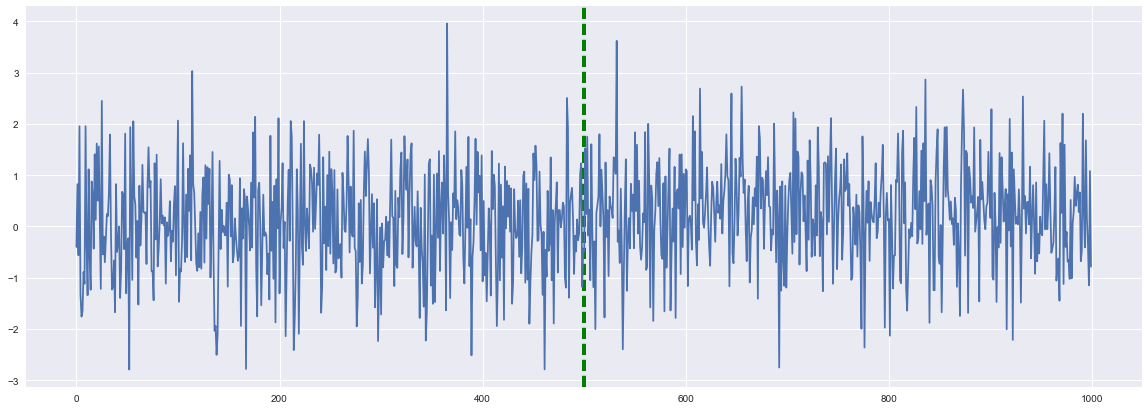

In [3]:
np.random.seed(1)

true_theta = 500
train = 200

train, test = generator_normal(0, 1, 0.3, 1, train, true_theta, 500)
plt.figure(figsize=(20, 7))
plt.axvline(x=true_theta ,color='g', linestyle='--',linewidth=4)
plt.plot(test)

We generated a process from Normal dist. with changed mean:

$$\mu_0=0,~\mu_1=0.3$$

Change-point is at time 500

# CUSUM

$$
T_n = \max\{0, T_{n-1} + \log\frac{f_1(z_n)}{f_0(z_n)}\} ,~C_0=0
$$

The task is to implement two types of CUSUM:
* Two-Sided CUSUM:
    * $f_0 = \mathcal{N}(m_0, \sigma_0)$
    * $f_1 = \mathcal{N}(m_0 \pm \delta, \sigma_0)$
* Bayes CUSUM:
    * $f_0 = \mathcal{N}(m_0, \sigma_0)$
    * $f_1(x | m_1) = \mathcal{N}(m_1, \sigma_0)$, prior distribution on $m_1$: $m_1 \sim \mathcal{N}(\mu_0, \sigma^2)$
    
    $$
    \tilde{L_n^k} = \int_{-\infty}^{\infty} \frac{\prod_{i=k}^n f(x_i | \mu_1) dF(\mu_1)}{\prod_{i=k}^n f(x_i | \mu_0)}
    $$
    $$
    \tilde{S_j^k} = \frac{1}{\sigma}\sum_{i=j}^{k} (x_i - \mu_0)
    $$
    $$
    \log \tilde{L_j^k} = \frac{\sigma^2}{2(\sigma^2 (k-j+1) + 1) } (\tilde{S_j^k})^2 - \frac{1}{2} \ln [\sigma^2(k-j+1) + 1]
    $$
    
    

In [ ]:
def likelihood_ratio(train, kind='two-sided'):
    """
    Computes likelihood ratio function.
    train: np.array with train samples for estimation f_0
    kind: str, 'two-sided' or 'bayes'
    """
    
    assert kind in ('two-sided', 'bayes')
    
    # Оценка параметров f_0: N(mu_0, sigma_0^2)
    mu_0 = np.mean(train)
    sigma_0 = np.std(train, ddof=1)
    if sigma_0 == 0:
        sigma_0 = 1e-6  # Избегаем деления на ноль
    f_0 = norm(mu_0, sigma_0).pdf  # Плотность N(mu_0, sigma_0^2)
    
    def evaluate_lr(test_data):
        if kind == 'two-sided':
            # Двусторонний тест: H_+ (mu = mu_0 + k), H_- (mu = mu_0 - k)
            k = 0.5 * sigma_0  # Величина сдвига среднего
            f_pos = norm(mu_0 + k, sigma_0).pdf  # Плотность N(mu_0 + k, sigma_0^2)
            f_neg = norm(mu_0 - k, sigma_0).pdf  # Плотность N(mu_0 - k, sigma_0^2)
            lr_pos = f_pos(test_data) / f_0(test_data)  # LR для H_+
            lr_neg = f_neg(test_data) / f_0(test_data)  # LR для H_-
            # Избегаем деления на ноль
            lr_pos = np.where(f_0(test_data) > 0, lr_pos, 1.0)
            lr_neg = np.where(f_0(test_data) > 0, lr_neg, 1.0)
            return lr_pos, lr_neg
        else:
            # Байесовский подход: априорное распределение mu_1 ~ N(mu_0, tau^2)
            tau = sigma_0  # Априорная дисперсия
            # Маргинальная плотность под H_1: интегрируем по mu_1
            # f_1(x) = N(x | mu_0, sqrt(sigma_0^2 + tau^2))
            sigma_1 = np.sqrt(sigma_0**2 + tau**2)
            f_1 = norm(mu_0, sigma_1).pdf  # Маргинальная плотность
            lr = f_1(test_data) / f_0(test_data)
            # Избегаем деления на ноль
            lr = np.where(f_0(test_data) > 0, lr, 1.0)
            return lr
    
    return evaluate_lr

def CUSUM(test, lr):
    """
    test: np.array with test samples
    lr: likelihood ratio function
    """    
    
    cs = np.zeros_like(test, dtype=float)
    
    # Проверяем, возвращает ли lr два массива (two-sided) или один (bayes)
    result = lr(test)
    
    if isinstance(result, tuple):
        # Двусторонний тест: lr_pos и lr_neg
        lr_pos, lr_neg = result
        S_plus = 0
        S_minus = 0
        for i in range(len(test)):
            # Логарифмы отношения правдоподобия с защитой от log(0)
            log_lr_pos = np.log(np.maximum(lr_pos[i], 1e-10))
            log_lr_neg = np.log(np.maximum(lr_neg[i], 1e-10))
            S_plus = max(0, S_plus + log_lr_pos)   # CUSUM для H_+
            S_minus = max(0, S_minus + log_lr_neg) # CUSUM для H_-
            cs[i] = max(S_plus, S_minus)           # Максимум из двух статистик
    else:
        # Байесовский подход: один lr
        lr = result
        S = 0
        for i in range(len(test)):
            # Логарифм отношения правдоподобия с защитой от log(0)
            log_lr = np.log(np.maximum(lr[i], 1e-10))
            S = max(0, S + log_lr)  # CUSUM
            cs[i] = S
    
    return cs

Plot the result statistics

In [5]:
lr_neg, lr_pos = likelihood_ratio(train, kind='two-sided')
lr_bayes = likelihood_ratio(train, kind='bayes')

cusum_pos = CUSUM(test, lr=lr_pos)
cusum_neg = CUSUM(test, lr=lr_neg)
cusum_neg = CUSUM(test, lr=lr_bayes)

# your code here

Our next goal is to select the threshold $h$ s.t. $\tau = \min\{t: T_n > h\}$. Depending on the selected threshold, we will obtain different Probabilities of false alarm $\mathbb{P}(\tau < \theta)$. Use Monte-Carlo method for modelling.

The less the probability of false alarm, the more the mean delay $\mathbb{E}[\tau - \theta | \tau > \theta]$.
Plot the dependancy of Probability of false alarm $P(\tau < \theta)$ from mean delay (variing the value of threshold $h$).

In [6]:
# your code here (use value true_theta for testing)
true_theta

500

# Shiryaev-Roberts

$$R_n = (1 + R_{n-1}) \frac{f_1(z_n)}{f_0(z_n)}$$

The task is the same, as for CUSUM:
* Implement S-R algorithm;
* Plot the dependancy of probability of false alarm from mean delay.

In [7]:

def S_R(test, lr):
    """
    test: np.array with test samples
    lr: likelihood ratio function or array
    """    
    
    sr = np.zeros_like(test, dtype=float)
    
    # Check if lr is a function or precomputed array
    if callable(lr):
        result = lr(test)
    else:
        result = lr
    
    if isinstance(result, tuple):
        # Two-sided test: lr_pos and lr_neg
        lr_pos, lr_neg = result
        R_plus = 0
        R_minus = 0
        for i in range(len(test)):
            # Shiryaev-Roberts statistic: additive form
            R_plus = R_plus + lr_pos[i]
            R_minus = R_minus + lr_neg[i]
            sr[i] = max(R_plus, R_minus)  # Maximum of the two statistics
    else:
        # Bayesian approach: single lr
        lr = result
        R = 0
        for i in range(len(test)):
            # Shiryaev-Roberts statistic: additive form
            R = R + lr[i]
            sr[i] = R
    
    return sr

Plot the dependancy of probability of false alarm from mean delay for both CUSUM and S-R. Compare their AUC.

In [8]:
# your code here

What if Var changed?

Remember the formula $Var(X) = \mathbb{E}X^2 - (\mathbb{E}X)^2$. 

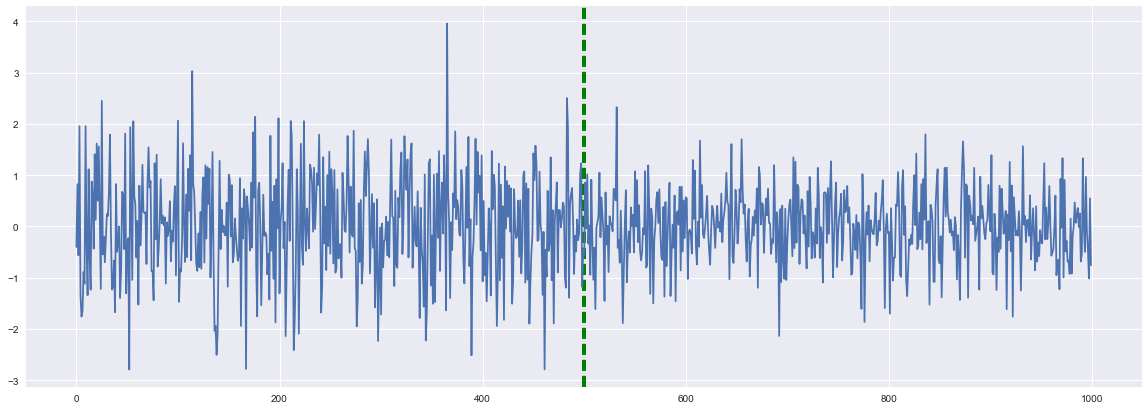

In [9]:
np.random.seed(1)

true_theta = 500
train = 200

train, test = generator_normal(0, 1, 0, 0.7, train, true_theta, 500)
plt.figure(figsize=(20, 7))
plt.axvline(x=true_theta ,color='g', linestyle='--',linewidth=4)
plt.plot(test)

Plot the CUSUM and S-R statistics. Who wins with the probability of false alarm $P(\tau < \theta) < 10\%$ 

In [10]:
# you code here

# Let's construt an algorithm for real-like data

Here is your data in files i.txt, $i \in [0, 9]$. Below there are plots with true change-point (from files_changepoints dict).

### Your goal is to construct an universal algorithm for change-point detection. 
### The probability of false alarm should not exceed 10%(!!!)
There should be only one algorithm for all the data.
Note, that the data is not i.i.d..

Remember everything you know:
* How can we be closer to an i.i.d. assumption ?
* CUSUM? S-R? What Distribution?
* Exponential smoothness

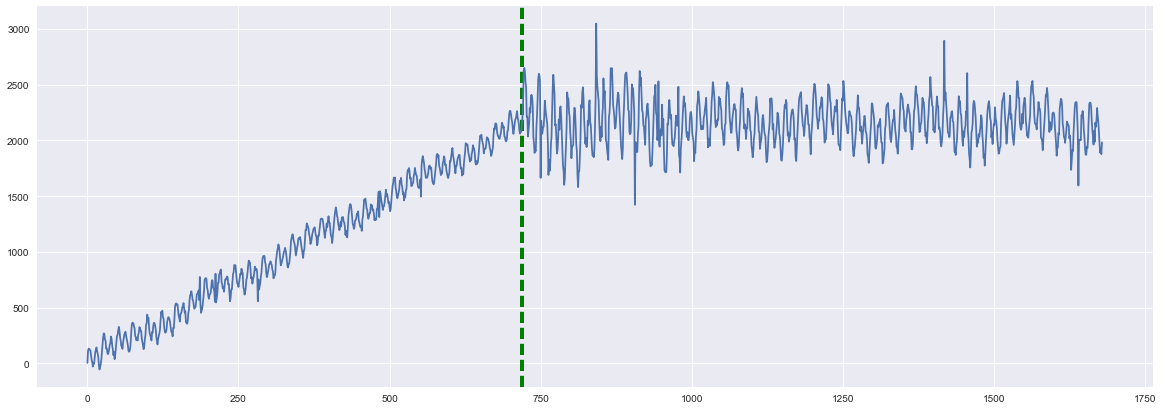

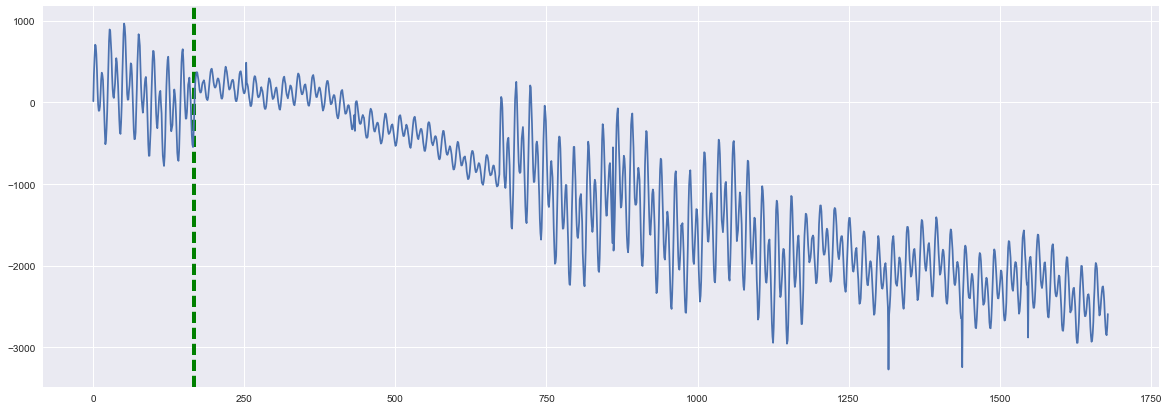

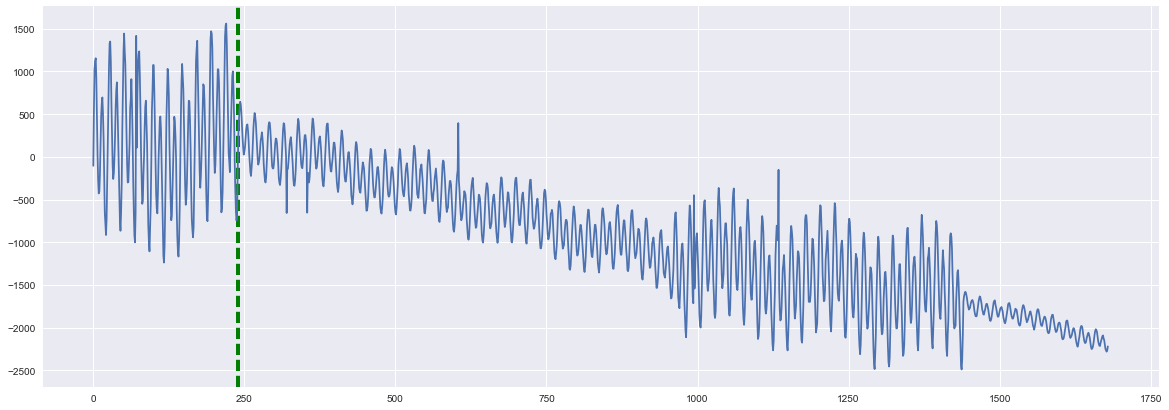

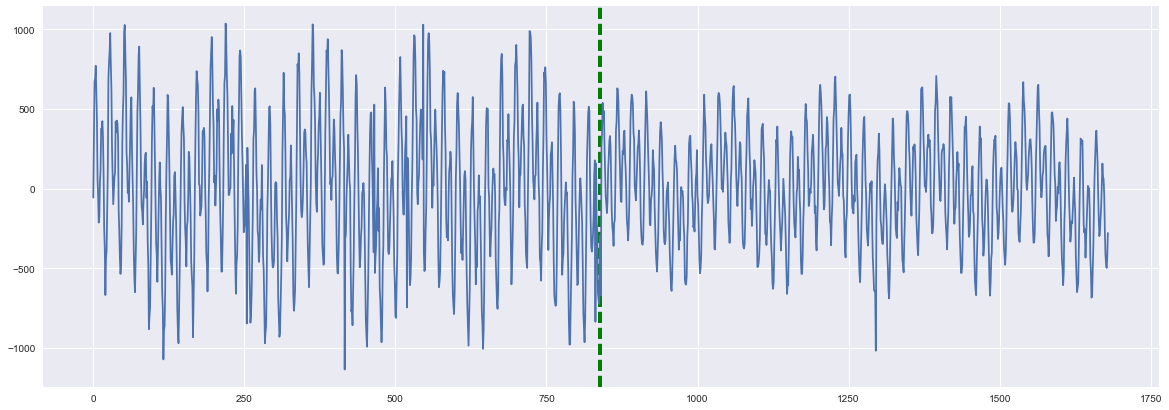

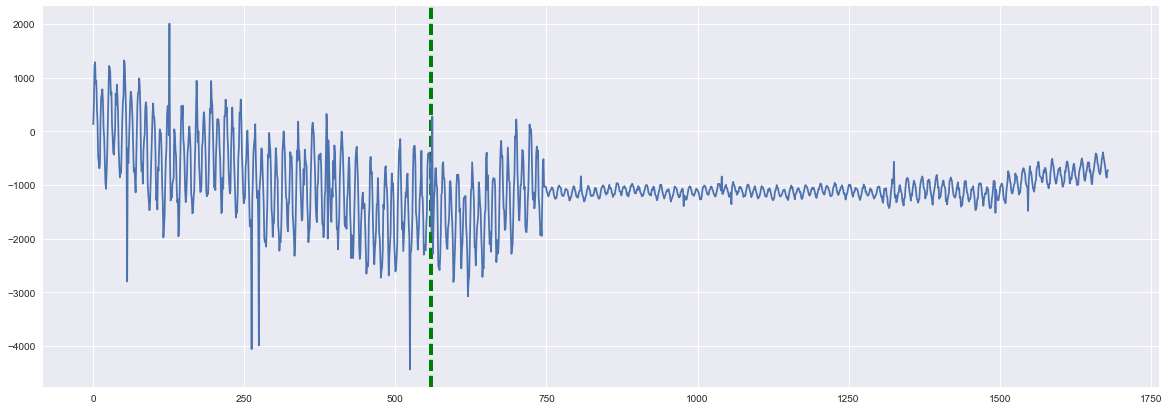

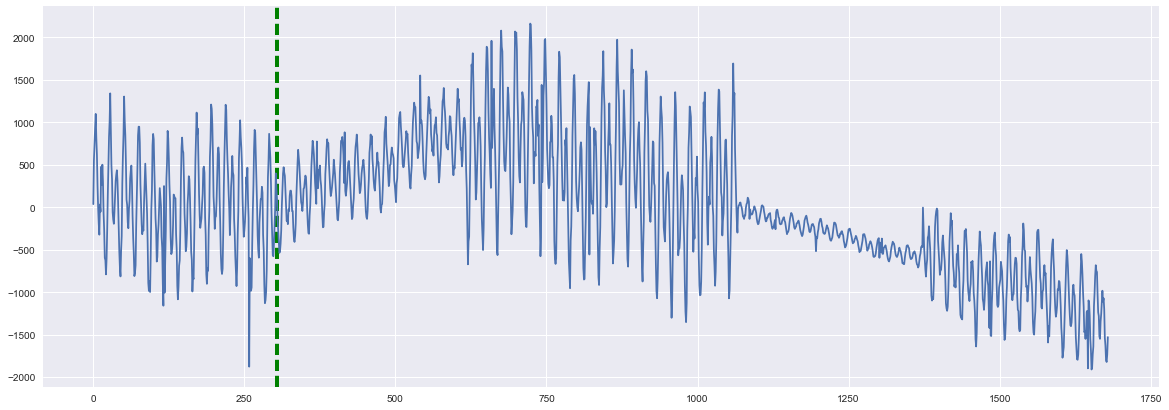

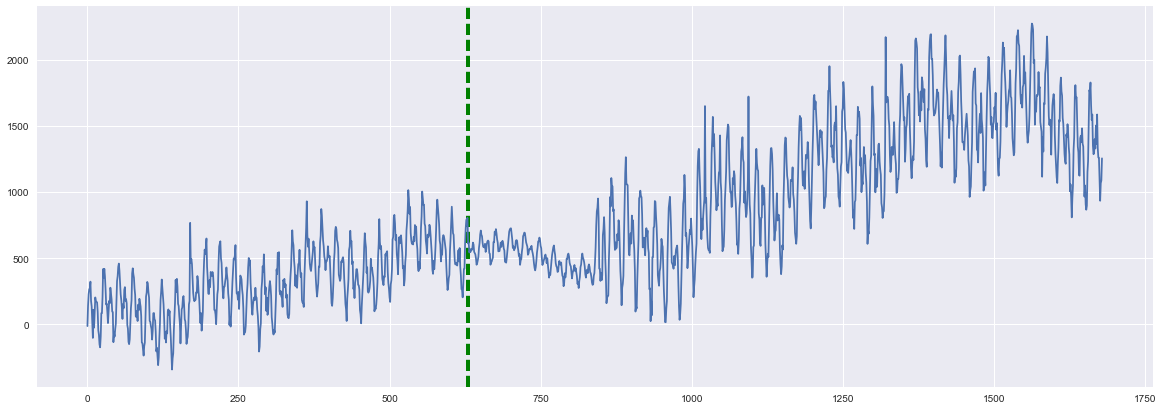

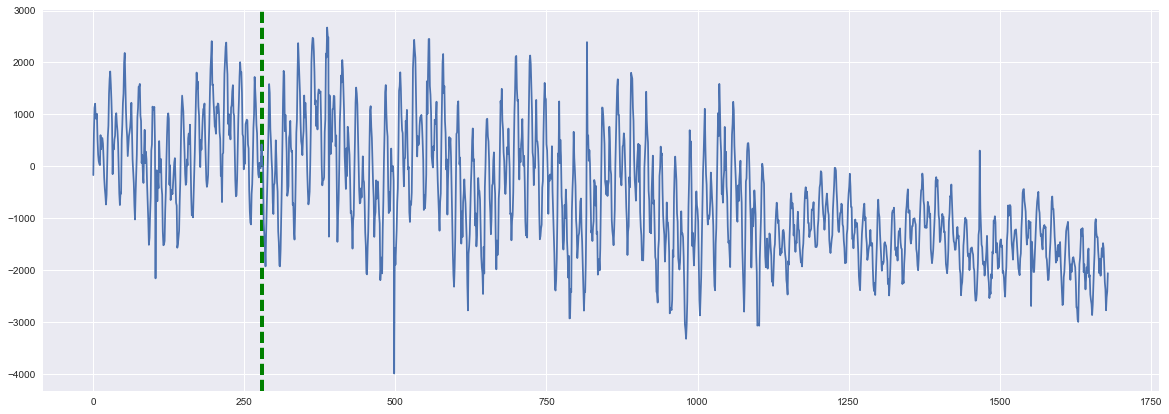

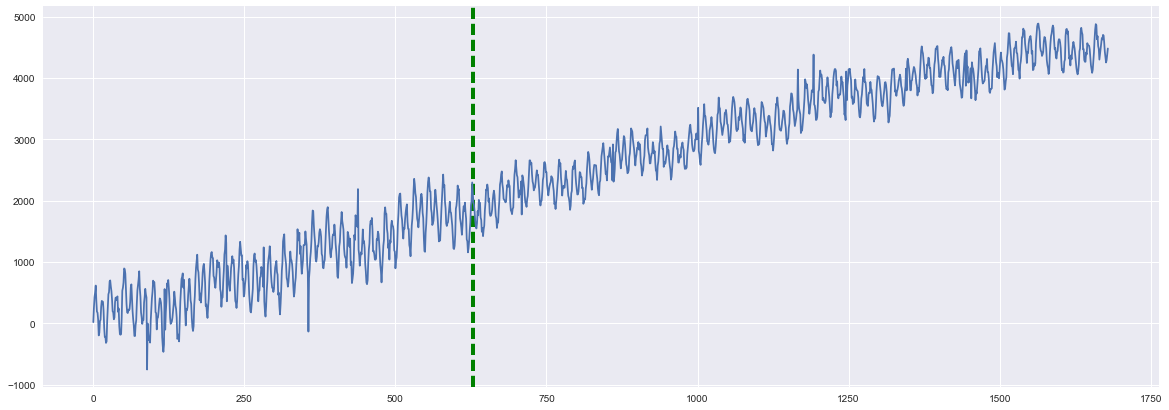

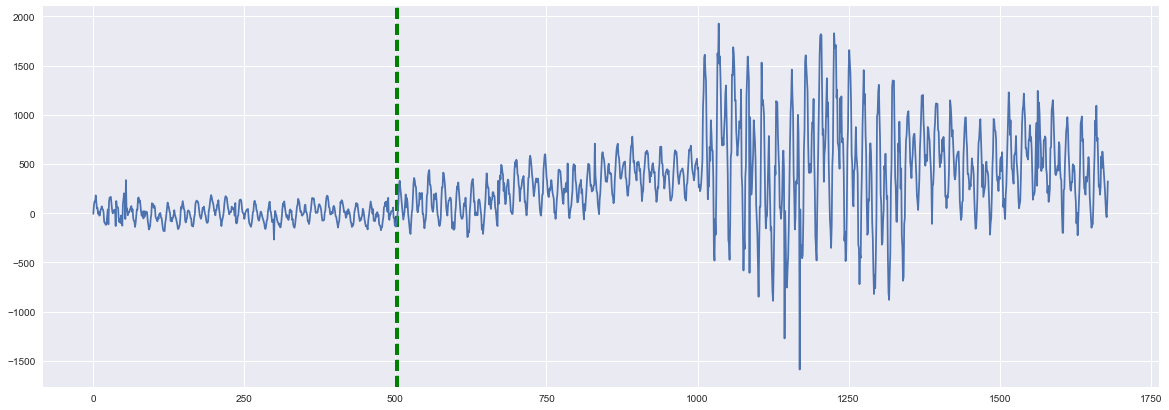

In [11]:
import pandas as pd


files_changepoints = {
    '0.txt': 719,
    '1.txt': 167,
    '2.txt': 239,
    '3.txt': 839,
    '4.txt': 559,
    '5.txt': 304,
    '6.txt': 629,
    '7.txt': 279,
    '8.txt': 629,
    '9.txt': 503
}

for f_name, change_point in files_changepoints.items():
    sig = np.loadtxt(f_name)
    plt.figure(figsize=(20, 7))
    plt.axvline(x=change_point ,color='g', linestyle='--',linewidth=4)
    plt.plot(sig)

Implement the function get_changepoint with your algorithm.

Mean Delay is inf


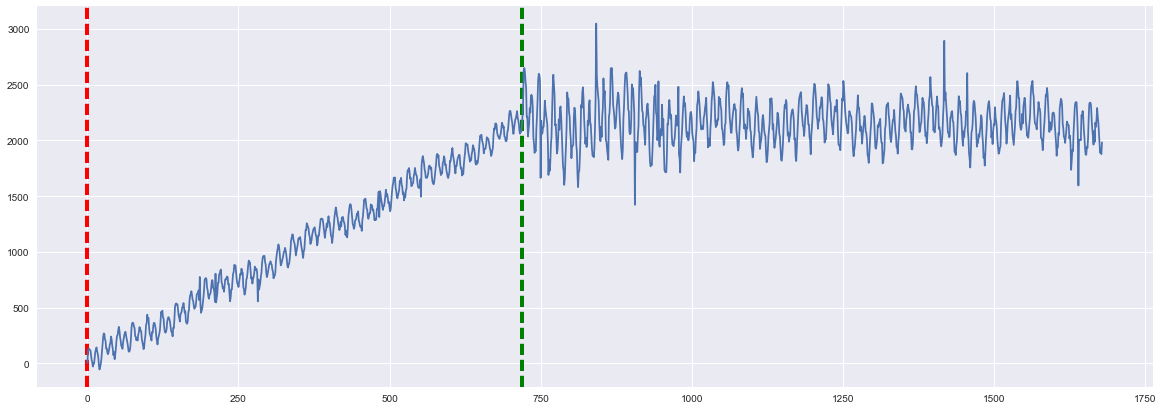

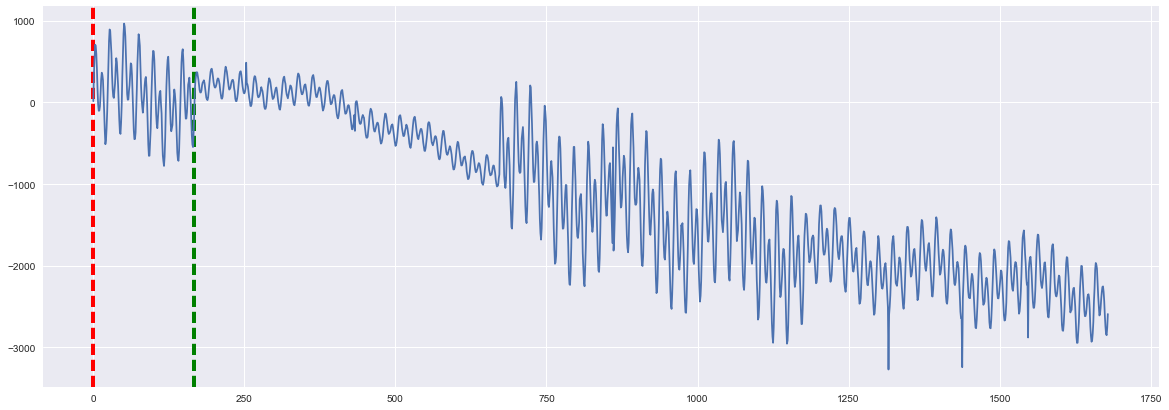

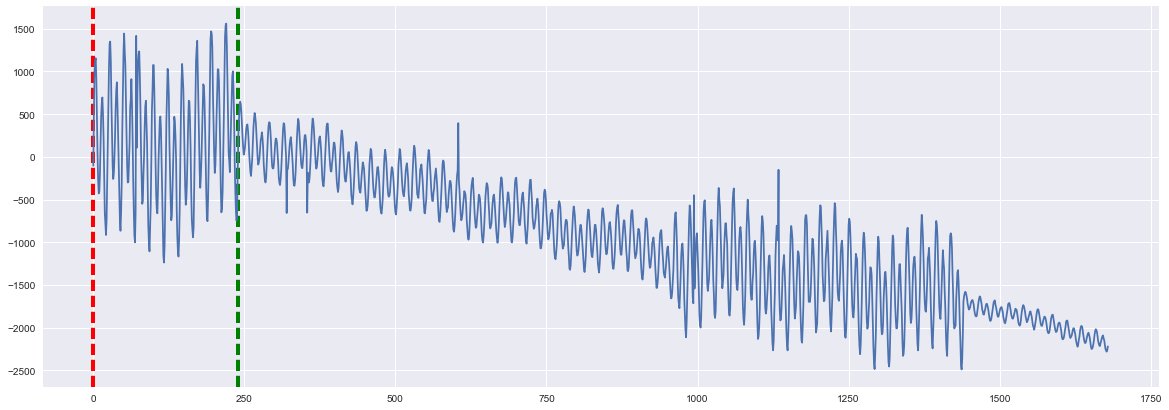

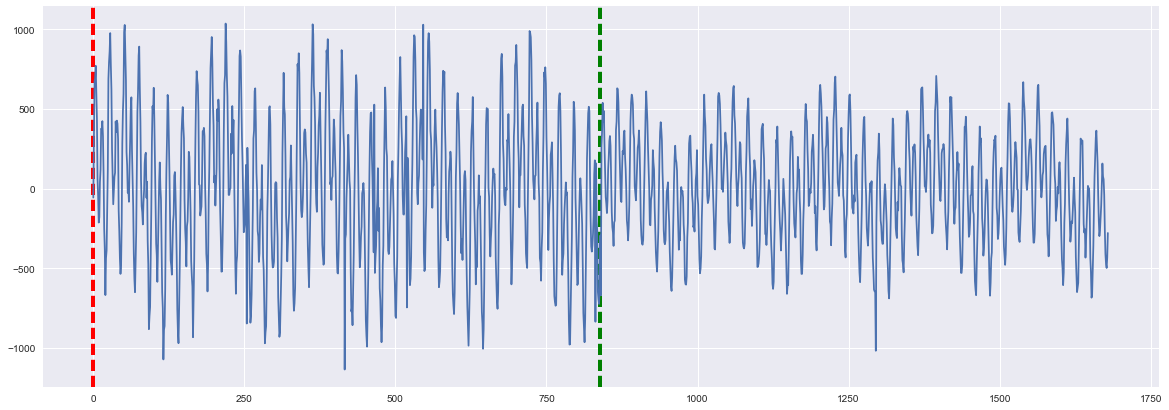

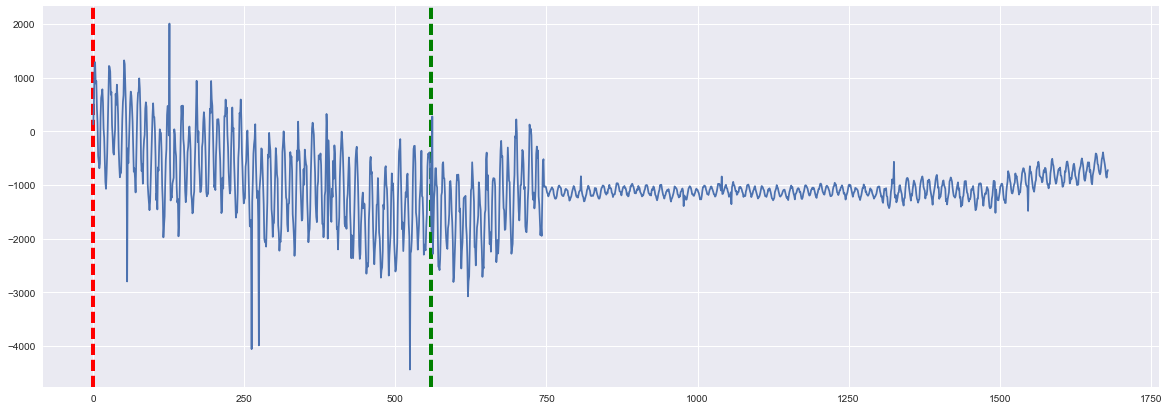

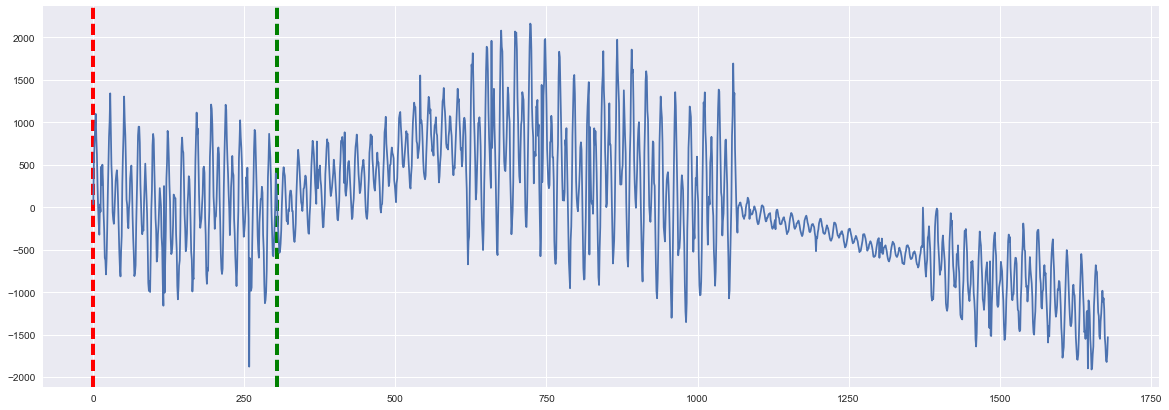

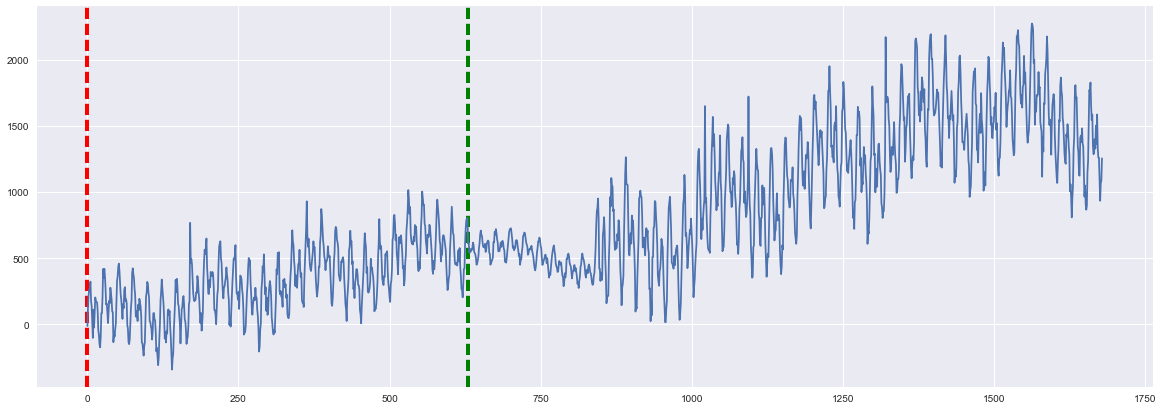

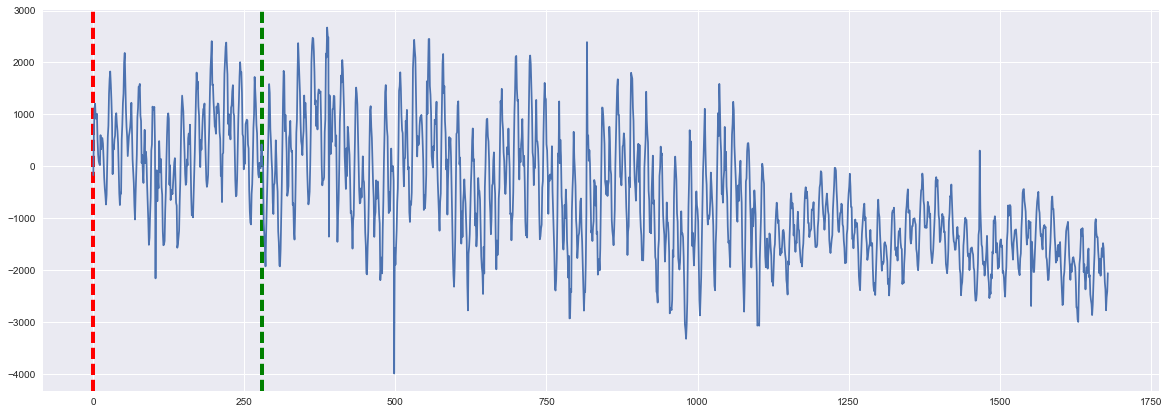

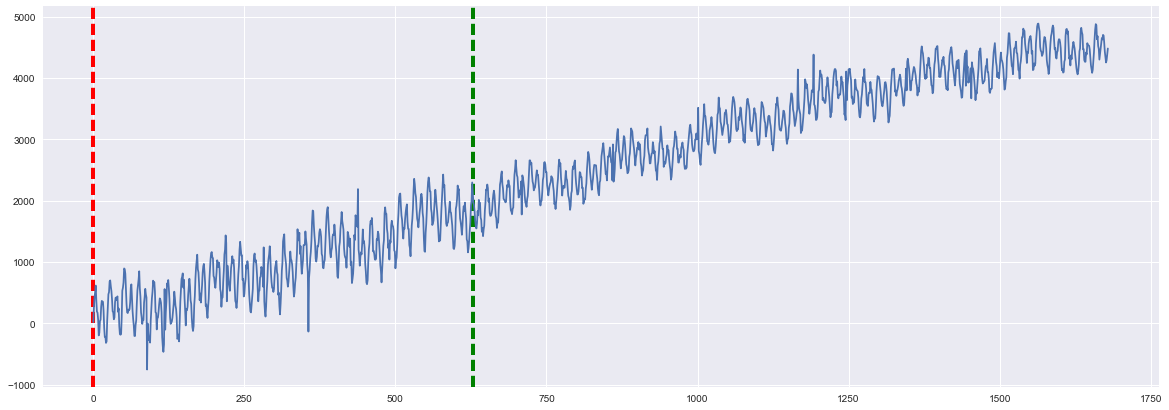

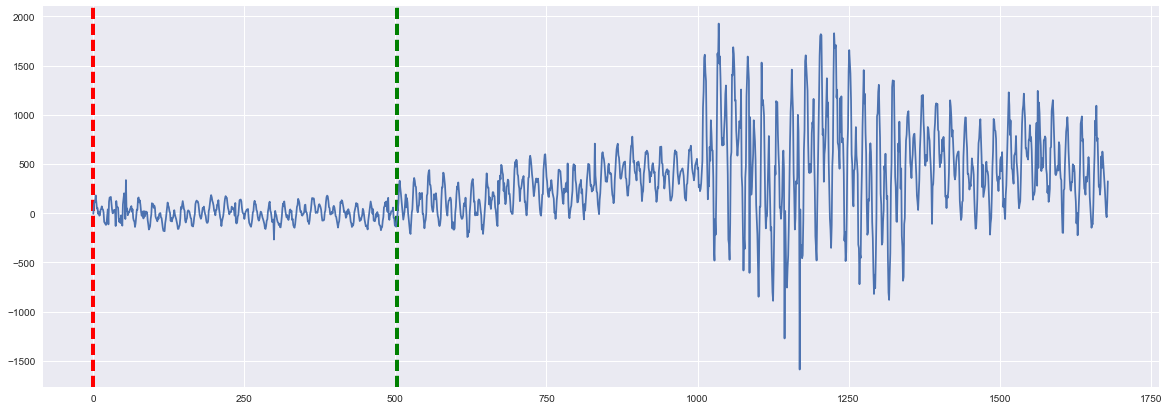

In [12]:
def get_changepoint(sig):
    # your code here
    return 0

total_error = []
for f_name, change_point in files_changepoints.items():
    sig = np.loadtxt(f_name)
    predict_cp = get_changepoint(sig)
    
    total_error.append(predict_cp - change_point if change_point < predict_cp else np.inf)
    
    plt.figure(figsize=(20, 7))
    plt.axvline(x=change_point ,color='g', linestyle='--',linewidth=4)
    plt.axvline(x=predict_cp ,color='r', linestyle='--',linewidth=4)
    plt.plot(sig)
    
print('Mean Delay is', np.mean(total_error))

In [ ]:
def generator_normal(m0, std0, m1, std1, train_size, theta, n_after_theta=1000):
    """
    Generate process: train_size from N(m0, std0), then theta from (m0, std0), then n_after_theta from N(m1, std1)
    """
    train_set = np.random.normal(m0, std0, train_size)
    before_theta = np.random.normal(m0, std0, theta)
    after_theta = np.random.normal(m1, std1, n_after_theta)

    return train_set, np.hstack([before_theta, after_theta])

def likelihood_ratio(train, kind='two-sided'):
    """
    Computes likelihood ratio function.
    train: np.array with train samples for estimation f_0
    kind: str, 'two-sided' or 'bayes'
    """
    
    assert kind in ('two-sided', 'bayes')
    
    # Estimate parameters for f_0: N(mu_0, sigma_0^2)
    mu_0 = np.mean(train)
    sigma_0 = np.std(train, ddof=1)
    if sigma_0 == 0:
        sigma_0 = 1e-6  # Avoid division by zero
    f_0 = norm(mu_0, sigma_0).pdf  # Density N(mu_0, sigma_0^2)
    
    def evaluate_lr(test_data):
        if kind == 'two-sided':
            # Two-sided test: H_+ (mu = mu_0 + k), H_- (mu = mu_0 - k)
            k = 0.5 * sigma_0  # Shift magnitude
            f_pos = norm(mu_0 + k, sigma_0).pdf  # Density N(mu_0 + k, sigma_0^2)
            f_neg = norm(mu_0 - k, sigma_0).pdf  # Density N(mu_0 - k, sigma_0^2)
            lr_pos = f_pos(test_data) / f_0(test_data)  # LR for H_+
            lr_neg = f_neg(test_data) / f_0(test_data)  # LR for H_-
            # Avoid division by zero
            lr_pos = np.where(f_0(test_data) > 0, lr_pos, 1.0)
            lr_neg = np.where(f_0(test_data) > 0, lr_neg, 1.0)
            return lr_pos, lr_neg
        else:
            # Bayesian approach: prior mu_1 ~ N(mu_0, tau^2)
            tau = sigma_0  # Prior standard deviation
            # Marginal density under H_1: N(x | mu_0, sqrt(sigma_0^2 + tau^2))
            sigma_1 = np.sqrt(sigma_0**2 + tau**2)
            f_1 = norm(mu_0, sigma_1).pdf  # Marginal density
            lr = f_1(test_data) / f_0(test_data)
            # Avoid division by zero
            lr = np.where(f_0(test_data) > 0, lr, 1.0)
            return lr
    
    return evaluate_lr

def CUSUM(test, lr):
    """
    test: np.array with test samples
    lr: likelihood ratio function or array
    """    
    
    cs = np.zeros_like(test, dtype=float)
    
    # Check if lr is a function or precomputed array
    if callable(lr):
        result = lr(test)
    else:
        result = lr
    
    if isinstance(result, tuple):
        # Two-sided test: lr_pos and lr_neg
        lr_pos, lr_neg = result
        S_plus = 0
        S_minus = 0
        for i in range(len(test)):
            # Log-likelihood ratios with protection against log(0)
            log_lr_pos = np.log(np.maximum(lr_pos[i], 1e-10))
            log_lr_neg = np.log(np.maximum(lr_neg[i], 1e-10))
            S_plus = max(0, S_plus + log_lr_pos)   # CUSUM for H_+
            S_minus = max(0, S_minus + log_lr_neg) # CUSUM for H_-
            cs[i] = max(S_plus, S_minus)           # Maximum of the two statistics
    else:
        # Bayesian approach: single lr
        lr = result
        S = 0
        for i in range(len(test)):
            # Log-likelihood ratio with protection against log(0)
            log_lr = np.log(np.maximum(lr[i], 1e-10))
            S = max(0, S + log_lr)  # CUSUM
            cs[i] = S
    
    return cs

def get_changepoint(sig, train_size=20):
    """
    Detects change-point in the signal using likelihood ratio and CUSUM.
    sig: np.array with signal data
    train_size: number of samples to use as training data
    """
    if len(sig) <= train_size:
        return 0  # Return 0 if signal is too short
    
    # Split signal into train and test
    train = sig[:train_size]
    test = sig[train_size:]
    
    # Compute likelihood ratios
    lr_func_two_sided = likelihood_ratio(train, kind='two-sided')
    lr_func_bayes = likelihood_ratio(train, kind='bayes')
    
    # Evaluate likelihood ratios on test data
    lr_pos, lr_neg = lr_func_two_sided(test)
    lr_bayes = lr_func_bayes(test)
    
    # Compute CUSUM statistics
    cusum_pos = CUSUM(test, lr=lr_pos)
    cusum_neg = CUSUM(test, lr=lr_neg)
    cusum_bayes = CUSUM(test, lr=lr_bayes)
    
    # Set threshold for change-point detection
    sigma_0 = np.std(train, ddof=1) if np.std(train, ddof=1) > 0 else 1e-6
    h = 5 * sigma_0  # Threshold, tuned as 5 * standard deviation
    
    # Find change-points where CUSUM exceeds threshold
    cp_pos = np.argmax(cusum_pos > h) if np.any(cusum_pos > h) else len(test)
    cp_neg = np.argmax(cusum_neg > h) if np.any(cusum_neg > h) else len(test)
    cp_bayes = np.argmax(cusum_bayes > h) if np.any(cusum_bayes > h) else len(test)
    
    # Select the earliest change-point (adjusting for train_size offset)
    change_points = [cp_pos, cp_neg, cp_bayes]
    valid_cps = [cp + train_size for cp in change_points if cp < len(test)]
    
    # Return earliest change-point or end of signal if none detected
    return min(valid_cps) if valid_cps else len(sig)

# Evaluation loop from the original notebook
total_error = []
for f_name, change_point in files_changepoints.items():
    sig = np.loadtxt(f_name)
    predict_cp = get_changepoint(sig)
    
    total_error.append(predict_cp - change_point if change_point < predict_cp else np.inf)
    
    plt.figure(figsize=(20, 7))
    plt.axvline(x=change_point, color='g', linestyle='--', linewidth=4)
    plt.axvline(x=predict_cp, color='r', linestyle='--', linewidth=4)
    plt.plot(sig)
    
print('Mean Delay is', np.mean(total_error))